# Load NATL60 data on a dask cluster via xarray

Inspiration: [here](https://github.com/pangeo-data/pangeo/blob/master/notebooks/newmann_ensemble_meteorology.ipynb)

In order to create a pure python script:
```
jupyter nbconvert --to script natl60_demo.ipynb
```


---

## Connect to dask cluster

In [2]:
%matplotlib inline
import os
import xarray as xr
import matplotlib
#matplotlib.use('agg')
import matplotlib.pyplot as plt
from glob import glob

# from dask.dot import dot_graph
from dask.diagnostics import Profiler, ResourceProfiler, CacheProfiler
from dask.diagnostics import visualize

In [30]:
from dask.distributed import Client
client = Client(scheduler_file=os.path.expanduser('~/dask/scheduler.json'))
client
#print(client)
#print(client._repr_html_())

Client Scheduler: tcp://10.148.1.64:8786 Dashboard: http://10.148.1.64:8787,Cluster Workers: 34 Cores: 136 Memory: 340.00 GB


---

## Open dataset


In [ ]:
dpath='/home/datawork-lops-osi/data/natl60/NATL60-CJM165/1d/3D/'
filenames = sorted(glob(dpath+'*_gridT.nc'))
print('Number of files available: %d' %len(filenames))

#filenames = filenames[:10]
print('Number of files processed: %d' %len(filenames))
chunks={'deptht': 1, 'x': 5422, 'y': 864}
#chunks={'deptht': 1, 'x': 5422, 'y':10}

ds = xr.open_mfdataset(filenames, concat_dim='time_counter', chunks=chunks, compat='equals')
#ds = xr.open_mfdataset(filenames, concat_dim='time_counter', chunks=chunks, compat='equals', autoclose=True, lock=True)


Number of files available: 365
Number of files processed: 365


In [19]:
print('ds size in GB {:0.2f}\n'.format(ds.nbytes / 1e9))
ds.info()

ds size in GB 8989.39

xarray.Dataset {
dimensions:
	axis_nbounds = 2 ;
	deptht = 300 ;
	time_counter = 100 ;
	x = 5422 ;
	y = 3454 ;

variables:
	float32 deptht(deptht) ;
		deptht:long_name = Vertical T levels ;
		deptht:units = m ;
		deptht:axis = Z ;
		deptht:positive = down ;
		deptht:bounds = deptht_bounds ;
	float32 nav_lat(y, x) ;
		nav_lat:standard_name = latitude ;
		nav_lat:long_name = Latitude ;
		nav_lat:units = degrees_north ;
		nav_lat:nav_model = grid_T ;
	float32 nav_lon(y, x) ;
		nav_lon:standard_name = longitude ;
		nav_lon:long_name = Longitude ;
		nav_lon:units = degrees_east ;
		nav_lon:nav_model = grid_T ;
	float32 deptht_bounds(time_counter, deptht, axis_nbounds) ;
	datetime64[ns] time_centered(time_counter) ;
		time_centered:standard_name = time ;
		time_centered:long_name = Time axis ;
		time_centered:time_origin = 1958-01-01 00:00:00 ;
		time_centered:bounds = time_centered_bounds ;
	datetime64[ns] time_counter(time_counter) ;
		time_counter:axis = T ;
		time_

In [20]:
# all arrays are dask arrays
for name, da in ds.data_vars.items():
    print(name, da.data)

deptht_bounds dask.array<concatenate, shape=(100, 300, 2), dtype=float32, chunksize=(1, 1, 2)>
time_counter_bounds dask.array<concatenate, shape=(100, 2), dtype=float64, chunksize=(1, 2)>
vosaline dask.array<concatenate, shape=(100, 300, 3454, 5422), dtype=float64, chunksize=(1, 1, 864, 5422)>
votemper dask.array<concatenate, shape=(100, 300, 3454, 5422), dtype=float64, chunksize=(1, 1, 864, 5422)>


---

## Overview of the data

Text(0.5,1,'sea surface temperature snapshot')

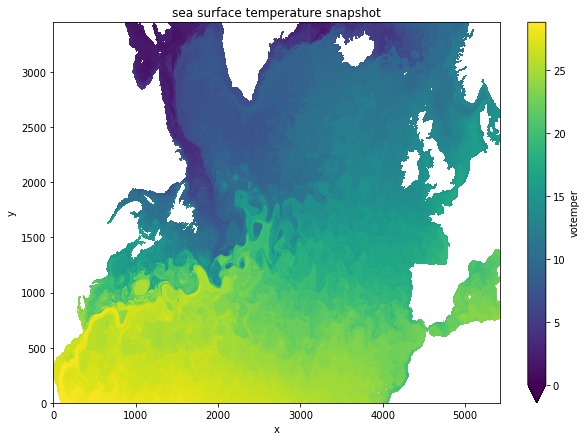

In [21]:
ds['votemper'].isel(deptht=0,time_counter=0).plot(vmin=0., robust=True, figsize=(10, 6))
plt.title('sea surface temperature snapshot')

---

## Compute a temporal average

In [22]:
%time temp_mean = ds['votemper'].isel(deptht=0).mean(dim='time_counter').compute()

CPU times: user 480 ms, sys: 364 ms, total: 844 ms
Wall time: 1min 31s


Text(0.5,1,'time averaged sea surface temperature')

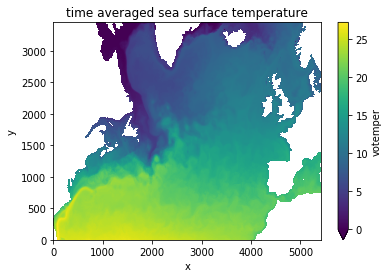

In [23]:
# and plot
temp_mean.plot(vmin=0., robust=True, figsize=(10, 6))
plt.title('time averaged sea surface temperature')

---

## Temporal and horizontal average

(ignores weighting by cell areas)

In [29]:
#%time temp_mean = ds['votemper'].isel(deptht=0).mean(dim=['time_counter','x','y']).compute()
%time temp_mean = ds['votemper'].mean(dim=['time_counter','x','y']).compute()
#%time temp_mean = ds['votemper'].mean(dim='time_counter').compute()

distributed.utils - ERROR - ('mean_agg-aggregate-bdac362b19ed6fb788f91ace00fa093d',)
Traceback (most recent call last):
  File "/home1/datahome/aponte/.miniconda3/envs/pangeo/lib/python3.6/site-packages/distributed/client.py", line 1257, in _gather
    st = self.futures[key]
KeyError: "('mean_agg-aggregate-bdac362b19ed6fb788f91ace00fa093d',)"

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home1/datahome/aponte/.miniconda3/envs/pangeo/lib/python3.6/site-packages/distributed/utils.py", line 232, in f
    result[0] = yield make_coro()
  File "/home1/datahome/aponte/.miniconda3/envs/pangeo/lib/python3.6/site-packages/tornado/gen.py", line 1055, in run
    value = future.result()
  File "/home1/datahome/aponte/.miniconda3/envs/pangeo/lib/python3.6/site-packages/tornado/concurrent.py", line 238, in result
    raise_exc_info(self._exc_info)
  File "<string>", line 4, in raise_exc_info
  File "/home1/datahome/aponte/.miniconda3

KeyboardInterrupt: 

In [28]:
print(temp_mean.values)

14.087741399877833


---

## Persistent data